# Urban Ecology Research Trend Analysis

In this notebook I'll analyse the trend of scientific research performed within an urban environment. I have chosen a few specific keywords related to Urban Ecology that I used to retrieve published papers using the OpenAlex API. I later enhanced my dataset be obtaining missing country data from the Research Organization Registry (ROR) to perform some geographical analysis.

**Note: I chose a date range starting on 1970 as that is the decade when the term Urban Ecology started getting traction. I cutoff my data in 2023 as there is still data missing from OpenAlex for the year 2024

## Section 1: Setup & Configuration

This section contains all the initial setup: imports, constants, database schemas, helper functions, and utility code needed for the analysis.

In [15]:
import os
import sys
import time
import math
import pycountry
import requests
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from itertools import combinations
from collections import Counter

BASE_URL = 'https://api.openalex.org/works'
DELAY = 1  # Small delay between requests
RETRY_DELAY = 5  # seconds before retrying on failure
YEAR_RANGE = '1970-2023' # We start on 1970 as that is considered the decade where urban ecology started gaining interest. We stop on 2023 as it's the last year with complete data
PAPERS_DB_PATH = 'papers.db'
CONTROL_DB_PATH = 'ecology_papers.db'

papers_schema = """
    paperId TEXT PRIMARY KEY,
    title TEXT,
    year INTEGER,
    authors TEXT,
    url TEXT,
    search_keyword TEXT,
    firstAuthorCountryIso TEXT,
    firstAuthorId TEXT,
    journal TEXT,
    citationCount INTEGER
"""

control_query = ['ecology']

query_list = [
    'urban ecology',
    'urban biodiversity',
    'urban ecosystem',
    'urban green spaces',
    'urban wildlife',
    'urban vegetation',
]

AUTHOR_URL = 'https://api.openalex.org/authors'

authors_schema = """
    authorId TEXT PRIMARY KEY,
    name TEXT,
    last_known_institution_name TEXT,
    last_known_institution_ror TEXT,
    country_code TEXT,
    country_name TEXT
"""

ROR_CLIENT_ID = 'U7CHDW7L27GVX0ZOUVTT0Z1QG8E1BL70'
ROR_BASE_URL = 'https://api.ror.org/v2/organizations'
ROR_DELAY = 0.1  # Conservative delay (600 requests/min against their 2000/min limit)
MAX_RETRIES = 3

color_map = {
    'urban ecology': '#6B9BD2',
    'urban biodiversity': '#E6A366',
    'urban green spaces': '#7FB069',
    'urban wildlife': '#D67B7B',
    'urban vegetation': '#B19CD9',
    'urban ecosystem': '#E6A8D0',
    'total': '#FFD700'
}

#### === Helper Functions ===

In [16]:
# === Paper Retrieval Helper functions ===

def save_cursor(keyword, cursor):
    """Save the current cursor for pagination"""
    with open(f'cursor_{keyword}.txt', 'w') as f:
        f.write(cursor)

def load_cursor(keyword):
    """Load the last cursor for pagination"""
    filename = f'cursor_{keyword}.txt'
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return f.read().strip()
    return None

def mark_done(keyword):
    with open(f'done_{keyword}.txt', 'w') as f:
        f.write('completed')

def is_done(keyword):
    return os.path.exists(f'done_{keyword}.txt')

def delete_cursor(keyword):
    """Clean up cursor tracking file when done"""
    filename = f'cursor_{keyword}.txt'
    if os.path.exists(filename):
        os.remove(filename)

def get_first_author_country(authorships_list):
    """Extract country ISO code prioritizing first author, with fallback to other authors"""
    if not authorships_list:
        return None
    
    first_authorship = authorships_list[0]
    institutions = first_authorship.get('institutions', [])
    
    for institution in institutions:
        country_code = institution.get('country_code')
        if country_code:
            return country_code
    
    for authorship in authorships_list[1:]:
        institutions = authorship.get('institutions', [])
        
        for institution in institutions:
            country_code = institution.get('country_code')
            if country_code:
                return country_code
    
    return None


# === Author Data Retrieval Helper Functions ===

def get_unique_author_ids():
    """Retrieve unique first author IDs from papers database"""
    with sqlite3.connect(PAPERS_DB_PATH) as conn:
        df_authors = pd.read_sql_query("""
        SELECT DISTINCT firstAuthorId 
        FROM papers 
        WHERE firstAuthorId IS NOT NULL 
        AND firstAuthorId != ''
        ORDER BY firstAuthorId
        """, conn)
    return df_authors['firstAuthorId'].tolist()

def save_author_to_db(author_data):
    """Save author information to database"""
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()
    
    c.execute(f'CREATE TABLE IF NOT EXISTS authors ({authors_schema})')
    
    author_id = author_data.get('id', '').replace('https://openalex.org/', '')
    name = author_data.get('display_name')
    
    institution_name = None
    institution_ror = None
    
    last_known_institutions = author_data.get('last_known_institutions', [])
    if last_known_institutions and len(last_known_institutions) > 0:
        institution = last_known_institutions[0]  # Get the most recent institution
        institution_name = institution.get('display_name')
        institution_ror = institution.get('ror')
        if institution_ror:
            institution_ror = institution_ror.replace('https://ror.org/', '')
    
    # Fallback: try old singular field in case API varies
    if not institution_name:
        last_known_institution = author_data.get('last_known_institution')
        if last_known_institution:
            institution_name = last_known_institution.get('display_name')
            institution_ror = last_known_institution.get('ror')
            if institution_ror:
                institution_ror = institution_ror.replace('https://ror.org/', '')
    
    try:
        c.execute('SELECT authorId FROM authors WHERE authorId = ?', (author_id,))
        existing = c.fetchone()
        
        if existing:
            c.execute("""
                UPDATE authors 
                SET name = ?, last_known_institution_name = ?, last_known_institution_ror = ?
                WHERE authorId = ?
            """, (name, institution_name, institution_ror, author_id))
        else:
            c.execute("""
                INSERT INTO authors 
                (authorId, name, last_known_institution_name, last_known_institution_ror, country_code, country_name)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (author_id, name, institution_name, institution_ror, None, None))
        
        conn.commit()
        return True
        
    except sqlite3.Error as e:
        print(f'DB error for author {author_id}: {e}')
        return False
    finally:
        conn.close()


# === Country Code Conversion Functions ===

def convert_alpha2_to_alpha3(alpha2_code):
    """Convert ISO 3166-1 alpha-2 country code to alpha-3"""
    try:
        country = pycountry.countries.get(alpha_2=alpha2_code)
        return country.alpha_3 if country else None
    except:
        return None

def get_country_name(alpha2_code):
    """Get country name from ISO 3166-1 alpha-2 country code"""
    try:
        country = pycountry.countries.get(alpha_2=alpha2_code)
        return country.name if country else None
    except:
        return None
    
# === ROR Data Helper Funtion ===
    
def get_ror_country_data_robust(ror_ids_batch, max_retries=MAX_RETRIES):
    """ROR data fetching with session reuse and error handling"""
    ror_data = {}
    headers = {
        'User-Agent': f'UrbanEcologyResearch/1.0 (https://github.com/Borjabor/UrbanEcologyResearchTrend; {ROR_CLIENT_ID})',
        'Accept': 'application/json',
        'Connection': 'keep-alive'
    }
    
    session = requests.Session()
    session.headers.update(headers)
    
    successful_requests = 0
    failed_requests = 0
    
    for ror_id in ror_ids_batch:
        success = False
        
        for attempt in range(max_retries):
            try:
                response = session.get(
                    f"{ROR_BASE_URL}/{ror_id}", 
                    timeout=15,
                    stream=False
                )
                
                if response.status_code == 200:
                    data = response.json()
                    locations = data.get('locations', [])
                    
                    if locations:
                        geonames = locations[0].get('geonames_details', {})
                        country_code = geonames.get('country_code')
                        country_name = geonames.get('country_name')
                        
                        ror_data[ror_id] = {
                            'country_code': country_code, 
                            'country_name': country_name
                        } if country_code else None
                    else:
                        ror_data[ror_id] = None
                    
                    successful_requests += 1
                    success = True
                    break
                    
                elif response.status_code == 429:
                    wait_time = 5 + (attempt * 2)
                    print(f"Rate limited on {ror_id}, waiting {wait_time}s...")
                    time.sleep(wait_time)
                    
                elif response.status_code == 404:
                    print(f"ROR ID not found: {ror_id}")
                    ror_data[ror_id] = None
                    success = True
                    break
                    
                else:
                    print(f"HTTP {response.status_code} for {ror_id} (attempt {attempt+1})")
                    if attempt < max_retries - 1:
                        time.sleep(2)
                    
            except requests.exceptions.Timeout:
                print(f"Timeout for {ror_id} (attempt {attempt+1})")
                if attempt < max_retries - 1:
                    time.sleep(3)
                    
            except requests.exceptions.ConnectionError:
                print(f"Connection error for {ror_id} (attempt {attempt+1})")
                if attempt < max_retries - 1:
                    time.sleep(5)
                    
            except requests.exceptions.RequestException as e:
                print(f"Request error for {ror_id} (attempt {attempt+1}): {e}")
                if attempt < max_retries - 1:
                    time.sleep(2)
        
        if not success:
            print(f"Failed to fetch {ror_id} after {max_retries} attempts")
            ror_data[ror_id] = None
            failed_requests += 1
        
        time.sleep(ROR_DELAY)
    
    session.close()
    return ror_data, successful_requests, failed_requests


In [17]:
# === Database Setup ===

def init_table(db_path, table_name, schema_sql):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(f'CREATE TABLE IF NOT EXISTS {table_name} ({schema_sql})')
    conn.commit()
    conn.close()
    
def save_paper_to_db(paper, keyword):
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()

    paper_id = paper.get('id', '').replace('https://openalex.org/', '')
    title = paper.get('title')
    year = paper.get('publication_year')
    citation_count = paper.get('cited_by_count', 0)
    
    primary_location = paper.get('primary_location', {})
    journal = None
    url = None
    if primary_location:
        source = primary_location.get('source', {})
        journal = source.get('display_name') if source else None
        url = primary_location.get('landing_page_url')
    
    authorships = paper.get('authorships', [])
    authors_list = []
    first_author_id = None
    first_author_country = None
    
    for authorship in authorships:
        author = authorship.get('author', {})
        author_name = author.get('display_name')
        if author_name:
            authors_list.append(author_name)
            
        if not first_author_id and author.get('id'):
            first_author_id = author.get('id').replace('https://openalex.org/', '')
            first_author_country = get_first_author_country([authorship])
    
    authors = ', '.join(authors_list)

    try:
        c.execute('SELECT search_keyword FROM papers WHERE paperId = ?', (paper_id,))
        existing = c.fetchone()
        
        if existing:
            existing_keywords = existing[0].split(', ') if existing[0] else []
            if keyword not in existing_keywords:
                existing_keywords.append(keyword)
                updated_keywords = ', '.join(existing_keywords)
                c.execute('UPDATE papers SET search_keyword = ? WHERE paperId = ?', 
                         (updated_keywords, paper_id))
        else:
            c.execute("""
                INSERT INTO papers 
                (paperId, title, year, authors, url, search_keyword, firstAuthorCountryIso, 
                 firstAuthorId, journal, citationCount)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (paper_id, title, year, authors, url, keyword, first_author_country, 
                  first_author_id, journal, citation_count))
        
        conn.commit()
    except sqlite3.Error as e:
        print(f'DB error for paper {paper_id}: {e}')
    finally:
        conn.close()

## Section 2: Data Fetching & Database Building

This section handles all API interactions and database population:
- Paper retrieval from OpenAlex API
- Author data collection from OpenAlex API
- ROR geographic enhancement
- Country code conversion utilities

The retrieval loops all have error handling, retry logic, and progress trackers to allow for "resuming" in case something goes wrong during the data retrieval.

**Note**: These cells build and populate the `papers.db` database with all research data.

In [ ]:
# Run this to clear the .txt progress trackers

# for keyword in query_list:
#     done_file = f'done_{keyword}.txt'
#     page_file = f'page_{keyword}.txt'
#     cursor_file = f'cursor_{keyword}.txt'
    
#     for file_path in [done_file, page_file, cursor_file]:
#         if os.path.exists(file_path):
#             os.remove(file_path)
#             print(f'Progress tracker "{file_path}" removed.')
  
# if os.path.exists(PAPERS_DB_PATH):      
#     os.remove(PAPERS_DB_PATH)
#     print(f'Output file "{PAPERS_DB_PATH}" removed.')

Progress tracker "done_urban ecology.txt" removed.
Progress tracker "done_urban biodiversity.txt" removed.
Progress tracker "done_urban ecosystem.txt" removed.
Progress tracker "done_urban green spaces.txt" removed.
Progress tracker "done_urban wildlife.txt" removed.
Progress tracker "done_urban vegetation.txt" removed.
Output file "papers.db" removed.


In [ ]:
# === Main loop for paper retrieval from OpenAlex ===

init_table(PAPERS_DB_PATH, 'papers', papers_schema)

for keyword in query_list:
    print(f'\nProcessing keyword: "{keyword}"')

    if is_done(keyword):
        print(f'Keyword "{keyword}" already completed. Skipping.')
        continue

    current_cursor = load_cursor(keyword)
    if current_cursor:
        print(f'Resuming from saved cursor for "{keyword}"')
        cursor = current_cursor
    else:
        print(f'Starting fresh for keyword "{keyword}"')
        cursor = '*'

    retrieved = 0
    page_count = 0

    while True:
        page_count += 1
        
        params = {
            'search': keyword,
            'filter': f'type:journal-article|book|book-chapter|monograph,publication_year:{YEAR_RANGE}',
            'per_page': 200,
            'cursor': cursor,
            'mailto': 'andre.borja.miranda@gmail.com'
        }

        for attempt in range(2):
            try:
                sys.stdout.flush() # Flush statements to avoid an issue that waas happening where print statements were duplicated after the request
                
                response = requests.get(BASE_URL, params=params, timeout=30)
                response.raise_for_status()
                
                sys.stdout.flush()
                
                data = response.json()
                break
            except requests.exceptions.RequestException as e:
                print(f'Request error on attempt {attempt+1} for "{keyword}" page {page_count}: {e}')
                if attempt == 0:
                    print(f'Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('Skipping this batch due to repeated failure.')
                    data = None

        if data is None:
            print(f'No data retrieved for keyword "{keyword}" page {page_count}, breaking loop.')
            break

        if 'error' in data:
            print(f'API Error for "{keyword}": {data.get("message", "Unknown error")}')
            break

        papers = data.get('results', [])
        if not papers:
            print(f'No more papers available for "{keyword}" (reached end of results)')
            print(f'Completed all available results for "{keyword}" (total: {retrieved} papers across {page_count} pages)')
            delete_cursor(keyword)
            mark_done(keyword)
            break

        retrieved += len(papers)
        print(f'Page {page_count}: {retrieved} papers retrieved for "{keyword}"')

        for paper in papers:
            save_paper_to_db(paper, keyword)

        meta = data.get('meta', {})
        next_cursor = meta.get('next_cursor')
        
        if next_cursor:
            cursor = next_cursor
            save_cursor(keyword, cursor)
            time.sleep(DELAY)
            
        else:
            #Fallback redundancy in case the "if not papers" check fails
            print(f'No more cursor available for "{keyword}" (total: {retrieved} papers across {page_count} pages)')
            delete_cursor(keyword)
            mark_done(keyword)
            break

print('\nAll keywords processed.')


Processing keyword: "ecology"
Starting fresh for keyword "ecology"
Page 1: 200 papers retrieved for "ecology"
Page 1: 200 papers retrieved for "ecology"
Page 2: 400 papers retrieved for "ecology"
Page 2: 400 papers retrieved for "ecology"
Page 3: 600 papers retrieved for "ecology"
Page 3: 600 papers retrieved for "ecology"
Page 4: 800 papers retrieved for "ecology"
Page 4: 800 papers retrieved for "ecology"
Page 5: 1000 papers retrieved for "ecology"
Page 5: 1000 papers retrieved for "ecology"
Page 6: 1200 papers retrieved for "ecology"
Page 6: 1200 papers retrieved for "ecology"
Page 7: 1400 papers retrieved for "ecology"
Page 7: 1400 papers retrieved for "ecology"
Page 8: 1600 papers retrieved for "ecology"
Page 8: 1600 papers retrieved for "ecology"
Page 9: 1800 papers retrieved for "ecology"
Page 9: 1800 papers retrieved for "ecology"
Page 10: 2000 papers retrieved for "ecology"
Page 10: 2000 papers retrieved for "ecology"
Page 11: 2200 papers retrieved for "ecology"
Page 11: 2200

#### === Author Data Retrieval Loop ===

In [ ]:
unique_author_ids = get_unique_author_ids()
print(f'Found {len(unique_author_ids)} unique first authors')

# Check existing authors
init_table(PAPERS_DB_PATH, 'authors', authors_schema)

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    try:
        existing_authors = pd.read_sql_query('SELECT COUNT(*) as count FROM authors', conn)
        existing_count = existing_authors['count'].iloc[0]
        print(f'Existing authors in database: {existing_count}')
        
        # Check institution coverage
        institution_stats = pd.read_sql_query("""
        SELECT 
            COUNT(*) as total_authors,
            COUNT(last_known_institution_name) as authors_with_institutions,
            COUNT(last_known_institution_ror) as authors_with_ror
        FROM authors
        """, conn).iloc[0]
        
        print(f'Current institution coverage:')
        print(f'  Authors with institution names: {institution_stats["authors_with_institutions"]:,} ({institution_stats["authors_with_institutions"]/institution_stats["total_authors"]*100:.1f}%)')
        print(f'  Authors with ROR IDs: {institution_stats["authors_with_ror"]:,} ({institution_stats["authors_with_ror"]/institution_stats["total_authors"]*100:.1f}%)')
        
    except:
        existing_count = 0
        print('No existing authors table found - created new one')

# Determine which authors to fetch - include those missing institution data
if existing_count > 0:
    with sqlite3.connect(PAPERS_DB_PATH) as conn:
        # Get authors that either don't exist OR are missing institution data
        authors_needing_fetch = pd.read_sql_query("""
        SELECT DISTINCT p.firstAuthorId
        FROM papers p
        WHERE p.firstAuthorId IS NOT NULL 
        AND p.firstAuthorId != ''
        AND (
            -- Author doesn't exist in authors table
            NOT EXISTS (SELECT 1 FROM authors a WHERE a.authorId = p.firstAuthorId)
            OR
            -- Author exists but missing institution data
            EXISTS (
                SELECT 1 FROM authors a 
                WHERE a.authorId = p.firstAuthorId 
                AND (a.last_known_institution_name IS NULL OR a.last_known_institution_name = '')
            )
        )
        ORDER BY p.firstAuthorId
        """, conn)
        
        authors_to_fetch = authors_needing_fetch['firstAuthorId'].tolist()
        
        # Separate new vs re-fetch for reporting
        existing_ids_set = set(pd.read_sql_query('SELECT authorId FROM authors', conn)['authorId'])
        new_author_ids = [aid for aid in authors_to_fetch if aid not in existing_ids_set]
        refetch_author_ids = [aid for aid in authors_to_fetch if aid in existing_ids_set]
        
        print(f'New authors to fetch: {len(new_author_ids)}')
        print(f'Existing authors to re-fetch (missing institutions): {len(refetch_author_ids)}')
        print(f'Total authors to process: {len(authors_to_fetch)}')
        
else:
    authors_to_fetch = unique_author_ids
    new_author_ids = authors_to_fetch
    refetch_author_ids = []
    print(f'Fetching all {len(unique_author_ids)} authors')

if len(authors_to_fetch) == 0:
    print('All authors already in database with complete institution data!')
else:
    total_authors = len(authors_to_fetch)
    processed = 0
    successful = 0
    updated_institutions = 0
    batch_size = 50  # OpenAlex max per request
    
    print(f'\nStarting enhanced author retrieval: {total_authors} authors')
    print(f'   - {len(new_author_ids)} new authors')
    print(f'   - {len(refetch_author_ids)} re-fetch for missing institutions')
    
    for i in range(0, total_authors, batch_size):
        batch = authors_to_fetch[i:i + batch_size]
        batch_urls = [f'https://openalex.org/{author_id}' for author_id in batch]
        
        params = {
            'filter': f'openalex_id:{"|".join(batch_urls)}',
            'per_page': len(batch),
            'mailto': 'andre.borja.miranda@gmail.com'
        }
        
        batch_num = i//batch_size + 1
        total_batches = (total_authors + batch_size - 1)//batch_size
        
        for attempt in range(2):
            try:
                print(f'Batch {batch_num}/{total_batches}: Fetching authors {i+1}-{min(i+batch_size, total_authors)}...')
                
                sys.stdout.flush()
                response = requests.get(AUTHOR_URL, params=params, timeout=30)
                response.raise_for_status()
                sys.stdout.flush()
                
                data = response.json()
                break
                
            except requests.exceptions.RequestException as e:
                print(f'Request error on attempt {attempt+1}: {e}')
                if attempt == 0:
                    print(f'Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('Skipping this batch due to repeated failure.')
                    data = None
        
        if data is None:
            continue
            
        if 'error' in data:
            print(f'API Error: {data.get("message", "Unknown error")}')
            continue
            
        authors = data.get('results', [])
        
        # Save each author to database and track institution updates
        batch_successful = 0
        batch_institution_updates = 0
        
        for author in authors:
            author_id = author.get('id', '').replace('https://openalex.org/', '')
            was_refetch = author_id in refetch_author_ids
            
            had_institution_before = False
            if was_refetch:
                with sqlite3.connect(PAPERS_DB_PATH) as conn:
                    existing_institution = pd.read_sql_query("""
                    SELECT last_known_institution_name 
                    FROM authors 
                    WHERE authorId = ?
                    """, conn, params=(author_id,))
                    
                    if not existing_institution.empty:
                        had_institution_before = bool(existing_institution.iloc[0]['last_known_institution_name'])
            
            if save_author_to_db(author):
                batch_successful += 1
                
                if was_refetch and not had_institution_before:
                    last_known_institutions = author.get('last_known_institutions', [])
                    if last_known_institutions and len(last_known_institutions) > 0:
                        institution = last_known_institutions[0]
                        if institution.get('display_name'):
                            batch_institution_updates += 1
        
        successful += batch_successful
        updated_institutions += batch_institution_updates
        processed += len(batch)
        
        print(f'Batch results: {batch_successful}/{len(batch)} saved, {batch_institution_updates} new institution data')
        
        # Rate limiting
        if i + batch_size < total_authors:
            time.sleep(DELAY)
    
    print(f'\nEnhanced author retrieval completed!')
    print(f'Results: {successful}/{processed} authors successfully processed')
    print(f'Institution updates: {updated_institutions} authors gained institution data')

# Enhanced Summary
print('\n' + '='*60)
print('ENHANCED AUTHOR DATA SUMMARY')
print('='*60)

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    summary_stats = pd.read_sql_query("""
    SELECT 
        COUNT(*) as total_authors,
        COUNT(last_known_institution_name) as authors_with_institutions,
        COUNT(last_known_institution_ror) as authors_with_ror,
        COUNT(DISTINCT last_known_institution_ror) as unique_ror_institutions,
        
        -- Coverage improvement metrics
        ROUND(COUNT(last_known_institution_name) * 100.0 / COUNT(*), 1) as institution_coverage_pct,
        ROUND(COUNT(last_known_institution_ror) * 100.0 / COUNT(*), 1) as ror_coverage_pct
    FROM authors
    """, conn)
    
    missing_institutions = pd.read_sql_query("""
    SELECT COUNT(*) as authors_missing_institutions
    FROM authors
    WHERE last_known_institution_name IS NULL OR last_known_institution_name = ''
    """, conn).iloc[0]['authors_missing_institutions']
    
    stats = summary_stats.iloc[0]
    print(f"Total authors: {stats['total_authors']:,}")
    print(f"Authors with institutions: {stats['authors_with_institutions']:,} ({stats['institution_coverage_pct']}%)")
    print(f"Authors with ROR IDs: {stats['authors_with_ror']:,} ({stats['ror_coverage_pct']}%)")
    print(f"Unique institutions (ROR): {stats['unique_ror_institutions']:,}")

#### === ROR Geographic Data Retrieval ===

In [ ]:

# Setup: Add country columns to authors table if needed
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    c = conn.cursor()
    c.execute("PRAGMA table_info(authors)")
    existing_columns = {col[1] for col in c.fetchall()}
    
    for col in ['country_code', 'country_name']:
        if col not in existing_columns:
            c.execute(f"ALTER TABLE authors ADD COLUMN {col} TEXT")
            print(f"Added {col} column to authors table")
    
    conn.commit()

# Check current progress and get remaining ROR IDs
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    progress_stats = pd.read_sql_query("""
    SELECT 
        COUNT(*) as total_authors_with_ror,
        COUNT(country_code) as authors_with_country,
        COUNT(*) - COUNT(country_code) as authors_missing_country
    FROM authors 
    WHERE last_known_institution_ror IS NOT NULL
    """, conn).iloc[0]
    
    print(f"CURRENT PROGRESS:")
    print(f"   Authors with ROR IDs: {progress_stats['total_authors_with_ror']:,}")
    print(f"   Already have country data: {progress_stats['authors_with_country']:,}")
    print(f"   Still need country data: {progress_stats['authors_missing_country']:,}")
    
    if progress_stats['authors_with_country'] > 0:
        completion_pct = (progress_stats['authors_with_country'] / progress_stats['total_authors_with_ror']) * 100
        print(f"   Progress: {completion_pct:.1f}% complete")
    
    ror_stats = pd.read_sql_query("""
    SELECT last_known_institution_ror, COUNT(DISTINCT authorId) as author_count
    FROM authors 
    WHERE last_known_institution_ror IS NOT NULL 
    AND (country_code IS NULL OR country_code = '')
    GROUP BY last_known_institution_ror
    ORDER BY author_count DESC
    """, conn)

if len(ror_stats) == 0:
    print("\nAll authors with ROR IDs already have country data!")
else:
    ror_ids_to_fetch = ror_stats['last_known_institution_ror'].tolist()
    total_authors_to_enhance = ror_stats['author_count'].sum()
    
    print(f"\nRESUMING ENHANCEMENT:")
    print(f"   Remaining ROR IDs: {len(ror_ids_to_fetch)}")
    print(f"   Authors to be enhanced: {total_authors_to_enhance:,}")
    
    # Small batches for better resumability
    batch_size = 25
    successful_total = 0
    failed_total = 0
    
    for i in range(0, len(ror_ids_to_fetch), batch_size):
        batch = ror_ids_to_fetch[i:i + batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(ror_ids_to_fetch) + batch_size - 1) // batch_size
        
        print(f"\nBatch {batch_num}/{total_batches}: Processing {len(batch)} ROR IDs...")
        
        ror_results, batch_successful, batch_failed = get_ror_country_data_robust(batch)
        
        with sqlite3.connect(PAPERS_DB_PATH) as conn:
            c = conn.cursor()
            batch_updates = 0
            
            for ror_id, data in ror_results.items():
                if data and data.get('country_code'):
                    try:
                        c.execute("""
                        UPDATE authors 
                        SET country_code = ?, country_name = ? 
                        WHERE last_known_institution_ror = ?
                        """, (data['country_code'], data['country_name'], ror_id))
                        batch_updates += 1
                    except sqlite3.Error as e:
                        print(f"DB error for ROR {ror_id}: {e}")
            
            conn.commit()
            
        successful_total += batch_updates
        failed_total += batch_failed
        
        print(f"Batch results: {batch_successful} successful, {batch_failed} failed, {batch_updates} DB updates")
        print(f"Overall progress: {batch_num}/{total_batches} batches ({(batch_num/total_batches)*100:.1f}%)")
    
    print(f"Final results: {successful_total} successful updates, {failed_total} failed requests")

print(f"\nUpdating papers with author-derived country data...")

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    result = conn.execute("""
    UPDATE papers 
    SET firstAuthorCountryIso = (
        SELECT a.country_code 
        FROM authors a 
        WHERE a.authorId = papers.firstAuthorId AND a.country_code IS NOT NULL
    )
    WHERE firstAuthorCountryIso IS NULL 
    AND EXISTS (
        SELECT 1 FROM authors a 
        WHERE a.authorId = papers.firstAuthorId AND a.country_code IS NOT NULL
    )
    """)
    
    updated_count = result.rowcount
    conn.commit()
    print(f"Updated {updated_count} papers with author-derived country data")

print(f"\n{'='*60}\nGEOGRAPHIC ENHANCEMENT SUMMARY\n{'='*60}")

with sqlite3.connect(PAPERS_DB_PATH) as conn:
    stats = pd.read_sql_query("""
    SELECT 
        -- Papers
        COUNT(*) as total_papers,
        COUNT(firstAuthorCountryIso) as papers_with_country,
        ROUND(COUNT(firstAuthorCountryIso) * 100.0 / COUNT(*), 1) as papers_coverage_pct,
        
        -- Authors  
        (SELECT COUNT(*) FROM authors) as total_authors,
        (SELECT COUNT(country_code) FROM authors) as authors_with_country,
        (SELECT COUNT(DISTINCT country_code) FROM authors WHERE country_code IS NOT NULL) as unique_countries
    FROM papers
    """, conn).iloc[0]

print(f"Papers: {stats['total_papers']:,} total, {stats['papers_with_country']:,} with country ({stats['papers_coverage_pct']}%)")
print(f"Authors: {stats['total_authors']:,} total, {stats['authors_with_country']:,} with country data")
print(f"Unique countries identified: {stats['unique_countries']:,}")
print("\nGeographic enhancement complete! Ready for visualization.")

🌍 PHASE 3: ROR GEOGRAPHIC ENHANCEMENT (RESUMABLE)
📈 CURRENT PROGRESS:
   Authors with ROR IDs: 41,457
   Already have country data: 41,453
   Still need country data: 4
   Progress: 100.0% complete

🎯 RESUMING ENHANCEMENT:
   Remaining ROR IDs: 4
   Authors to be enhanced: 4
   Realistic time estimate: ~0.2 minutes

📡 Batch 1/1: Processing 4 ROR IDs...
✅ Batch results: 4 successful, 0 failed, 4 DB updates
⏱️ Batch took 1.6s (0.41s per request)

🎉 ROR enhancement completed in 0.0 minutes!
📊 Final results: 4 successful updates, 0 failed requests

🔄 Updating papers with author-derived country data...
✅ Updated 2 papers with author-derived country data

GEOGRAPHIC ENHANCEMENT SUMMARY
📄 Papers: 66,047.0 total, 52,239.0 with country (79.1%)
👥 Authors: 45,805.0 total, 41,457.0 with country data
🌏 Unique countries identified: 191.0

🎯 Geographic enhancement complete! Ready for visualization.
✅ Batch results: 4 successful, 0 failed, 4 DB updates
⏱️ Batch took 1.6s (0.41s per request)

🎉 ROR enh

## Section 3: Data Analysis & Visualization

This section contains all the analytical work and visualizations:
- Exploratory data analysis
- Time series analysis and trend detection
- Regression analysis (linear vs exponential growth)
- Keyword correlation and co-occurrence analysis  
- Geographic mapping and institutional analysis

In [18]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_raw = pd.read_sql_query("""
    SELECT year, search_keyword
    FROM papers
    WHERE search_keyword IS NOT NULL AND search_keyword != ''
    """, conn)

rows = []
total_rows = []
for _, row in df_raw.iterrows():
    keywords = [k.strip() for k in row['search_keyword'].split(',')]
    total_rows.append({'year': row['year'], 'search_keyword': 'total'})
    for keyword in keywords:
        if keyword:
            rows.append({'year': row['year'], 'search_keyword': keyword})

df_keywords = pd.DataFrame(rows).groupby(['year', 'search_keyword']).size().reset_index(name='paper_count')
df_totals = pd.DataFrame(total_rows).groupby(['year', 'search_keyword']).size().reset_index(name='paper_count')
df_totals['search_keyword'] = 'total'

df_keywords = df_keywords.sort_values('year')
df_keywords.head()

,year,search_keyword,paper_count
0,1970,urban biodiversity,1
1,1970,urban ecology,7
2,1970,urban ecosystem,1
3,1970,urban green spaces,10
4,1970,urban vegetation,14


In [19]:
# === Control Analysis on all Ecology Published Papers ===

with sqlite3.connect(CONTROL_DB_PATH) as conn:
    df_control = pd.read_sql_query("""
    SELECT year, COUNT(*) as paper_count
    FROM papers
    WHERE search_keyword IS NOT NULL AND search_keyword != ''
    GROUP BY year
    ORDER BY year
    """, conn)

df_control['search_keyword'] = 'ecology'

df_combined = pd.concat([df_totals, df_control], ignore_index=True)

### Published Papers Time Series

We'll start with a simple analysis, simply looking at how many papers were published every year from 1970 to present day. 
First we look at the full data, looking at the sum of every paper published across every keyword, then at the data per keyword.

In [20]:
fig = px.line(
    df_combined,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map={
        **color_map,
        'ecology': "#2085D2"
    },
    title='Urban Ecology vs General Ecology Research Papers Published per Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()

We see a clear trend, where research volume quickly grows over the years. A curious data point happens around 2020, with a sharp drop in papers published, likely linked to the COVID pandemic, with numbers quickly picking up right after, following a similar slope as before.

  

That being said, the same trend can be observed for ecology as a whole. That is, scientific research is increasing in its totality, not only in urban environments. Although, looking at the latest data, urban research seem to be catching up, which could mean we might see just as many studies in cities as in more natural environments. Another possibility for that trend could be a result of the pandemic, where the scientific community started showing greater interest in urban environments post COVID, but that interst could decrease with time.

  

Although these are just guesses, and only with time we'll be able to confirm or refute either hypothesis.We see a clear trend, where research volume quickly grows over the years. A curious data point happens around 2020, with a sharp drop in papers published, likely linked to the COVID pandemic, with numbers quickly picking up right after, following a similar slope as before.

In [21]:
fig = px.line(
    df_keywords,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published per Year (by Keyword)',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


Same as above, every keyword follows this same trend. While some are clearly more popular than others, the graph curves are similar among all of the keywords. Now let's look at the trend of the entire breadth of 'ecology' research, a broad term that can encompass both studies in and out of the cities. Is this simply and overall trend the field or are researchers showing increasing interest in urban environemts?

==========================================================================
### Analyzing Keyword Relationship

Before anything else, I'll look into relationships between keywords, looking into wether they tend to appear together often. This should tell me if the choice of keywords was effective to cover a large portion of urban-related studies or if the overlap between any pair is too great, making them redundant.

Let's begin by analyzing the overall data, of all papers collected.

In [22]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_keyword_occurrence = pd.read_sql_query("""
    SELECT paperId, search_keyword, year
    FROM papers
    ORDER BY year
""", conn)


df_keyword_occurrence.rename(columns={'search_keyword': 'keywords'},inplace=True)

df_keyword_occurrence['keywords'] = df_keyword_occurrence['keywords'].str.split(',')
df_keyword_occurrence['keywords'] = df_keyword_occurrence['keywords'].apply(
    lambda lst: [kw.strip() for kw in lst]
)

df_keyword_occurrence.head()

,paperId,keywords,year
0,W594319624,[urban ecology],1970
1,W2902120482,"[urban ecology, urban green spaces, urban wild...",1970
2,W2475615813,"[urban ecology, urban green spaces, urban wild...",1970
3,W4206441299,"[urban ecology, urban vegetation]",1970
4,W4247273480,"[urban ecology, urban wildlife, urban vegetation]",1970


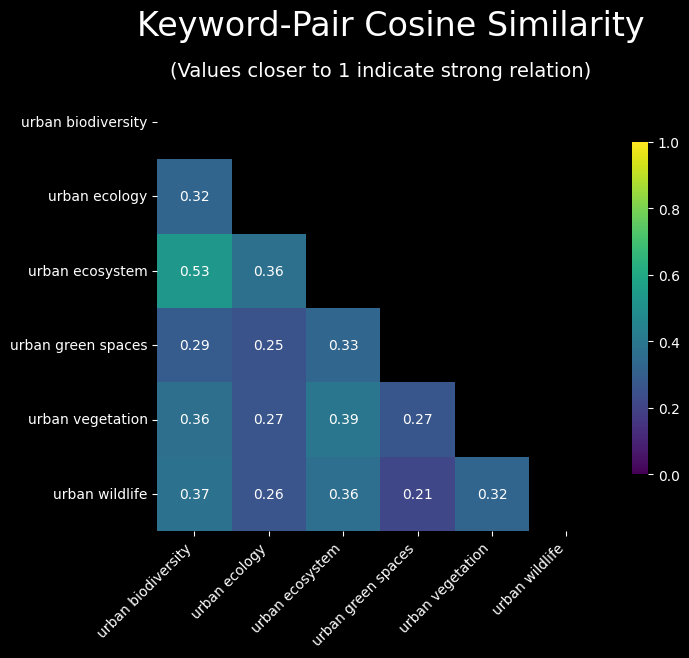

In [62]:
keyword_counts = pd.Series(dtype=int)
solo_counts = pd.Series(dtype=int)

for _, row in df_keyword_occurrence.iterrows():
    keywords = row['keywords']
    if len(keywords) == 1:
        # Single keyword paper
        kw = keywords[0].strip()
        solo_counts[kw] = solo_counts.get(kw, 0) + 1
        keyword_counts[kw] = keyword_counts.get(kw, 0) + 1
    else:
        # Multiple keyword paper
        for kw in keywords:
            kw = kw.strip()
            keyword_counts[kw] = keyword_counts.get(kw, 0) + 1

df_keyword_stats = pd.DataFrame({
    "total": keyword_counts,
    "solo": solo_counts
}).fillna(0)

df_keyword_stats["solo_ratio"] = (df_keyword_stats["solo"] / df_keyword_stats["total"]).round(2)

pair_counts = Counter()

for keyword_list in df_keyword_occurrence["keywords"]:
    unique_keywords = sorted([kw.strip() for kw in keyword_list])
    for kw1, kw2 in combinations(unique_keywords, 2):
        pair_counts[(kw1, kw2)] += 1
        
all_keywords = sorted(keyword_counts.index)

cooc_matrix = pd.DataFrame(np.zeros((len(all_keywords), len(all_keywords))),
                           index=all_keywords, columns=all_keywords)

for (kw1, kw2), count in pair_counts.items():
    cooc_matrix.at[kw2, kw1] = count / math.sqrt(keyword_counts[kw1] * keyword_counts[kw2])
num_keywords = len(cooc_matrix)
cell_size = 1.2

plt.figure(figsize=(num_keywords * cell_size, num_keywords * cell_size))

mask = np.triu(np.ones_like(cooc_matrix, dtype=bool))

sns.heatmap(cooc_matrix, 
            mask=mask,
            cmap="viridis",
            annot=True,
            fmt=".2f",
            square=True, 
            cbar_kws={"shrink": 0.6},
            vmin=0,
            vmax=1)

plt.suptitle("Keyword-Pair Cosine Similarity", fontsize=24, x=0.45, y=0.91)
plt.title("(Values closer to 1 indicate strong relation)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

We can see the keywords have relatively low similarity, meaning they do occur together occasionally, but mostly cover their own fields. This means my choice of keywords was an effective one, as they indicate we were able to cover more ground, so to speak, in obtaining papers representative of studies performed within an urban context.

Next I looked into temporal data, seeing how the relatioships changed over time. Since initial data was sparse, which can cause some issues with the similarity calculation, I went with 5-year intervals. That is, I grouped all of the data every 5 years before I performed the relationship analysis.

In [ ]:
df_keyword_pivot = df_keywords.pivot(index='search_keyword', columns='year', values='paper_count')
df_keyword_pivot.fillna(0, inplace=True)

year_pair_counts = {}

for _, row in df_keyword_occurrence.iterrows():
    year = row['year']
    year_bin = (year // 5) * 5
    keyword_list = row['keywords']
    
    unique_keywords = sorted([kw.strip() for kw in keyword_list])
    for kw1, kw2 in combinations(unique_keywords, 2):
        pair_key = f"{kw1} × {kw2}"
        
        if year_bin not in year_pair_counts:
            year_pair_counts[year_bin] = {}
        if pair_key not in year_pair_counts[year_bin]:
            year_pair_counts[year_bin][pair_key] = 0
        year_pair_counts[year_bin][pair_key] += 1

pair_time_data = []
for year_bin, pairs_dict in year_pair_counts.items():
    for pair, count in pairs_dict.items():
        pair_time_data.append({
            'year_bin': year_bin,
            'keyword_pair': pair,
            'cooccurrence_count': count
        })

df_pair_pivot = pd.DataFrame(pair_time_data).pivot(index='keyword_pair', columns='year_bin', values='cooccurrence_count')
df_pair_pivot.fillna(0, inplace=True)

keyword_year_data = []
for _, row in df_keywords.iterrows():
    year_bin = (row['year'] // 5) * 5
    keyword_year_data.append({
        'search_keyword': row['search_keyword'],
        'year_bin': year_bin,
        'paper_count': row['paper_count']
    })

df_keyword_year_counts = (pd.DataFrame(keyword_year_data)
                         .groupby(['search_keyword', 'year_bin'])['paper_count']
                         .sum()
                         .reset_index()
                         .pivot(index='search_keyword', columns='year_bin', values='paper_count'))
df_keyword_year_counts.fillna(0, inplace=True)

df_pair_similarity = df_pair_pivot.copy()

for pair_name in df_pair_similarity.index:
    kw1, kw2 = pair_name.split(' × ')
    
    for year_bin in df_pair_similarity.columns:
        if year_bin in df_keyword_year_counts.columns:
            kw1_count = df_keyword_year_counts.loc[kw1, year_bin] if kw1 in df_keyword_year_counts.index else 0
            kw2_count = df_keyword_year_counts.loc[kw2, year_bin] if kw2 in df_keyword_year_counts.index else 0
            
            if kw1_count > 0 and kw2_count > 0:
                df_pair_similarity.loc[pair_name, year_bin] = df_pair_pivot.loc[pair_name, year_bin] / math.sqrt(kw1_count * kw2_count)
            else:
                df_pair_similarity.loc[pair_name, year_bin] = 0

year_totals = df_pair_similarity.sum(axis=0)
active_years = year_totals[year_totals > 0].index
df_similarity_active = df_pair_similarity[active_years]

df_similarity_masked = df_similarity_active.replace(0, np.nan)\

fig_temporal = go.Figure(data=go.Heatmap(
    z=df_similarity_masked.values,
    x=[str(int(col)) for col in df_similarity_masked.columns],
    y=df_similarity_masked.index,
    colorscale='Viridis',
    hovertemplate='<b>%{y}</b><br>' +
                  'Period: %{x}<br>' +
                  'Cosine Similarity: %{z:.3f}<br>' +
                  '<extra></extra>',
    colorbar=dict(title='Cosine Similarity (0-1)'),
    showscale=True,
    zmin=0,
    zmax=1
))

fig_temporal.update_layout(
    title={
        'text': 'Keyword Pair Similarity Over Time (5-Year Intervals)<br><sub>(Lighter colors indicate stronger relationships; empty cells mean either keyword had no papers)</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title='5-Year Period',
    yaxis_title='Keyword Pairs',
    template='plotly_dark',
    width=1200,
    height=800,
    xaxis=dict(
        tickangle=45,
        side='bottom',
        showgrid=False
    ),
    yaxis=dict(
        autorange='reversed',
        showgrid=False
    ),
    font=dict(size=12)
)

fig_temporal.show()

A similar picture to our matrix above showed up here with the data over time. Relatioships didn't change much over time, with the one interesting case being the urban biodiversity X urban ecosystem case, which could mean a trend of shared research over time, though the value still isn't high enough to draw any conslusions.

==========================================================================
### Regression Analysis on All Papers Published

Seeing the keywords don't overlap a lot, we can move on with other analyses.


We'll start by performing linear regression analysis on our data. We'll test to see if our data follows better linear or exponential growth. To do that, we'll do the regression analysis on the data as is, then on the data after performing a log transform (this serves to "flatten a curve" on data seeing exponential growth).

COMPREHENSIVE GROWTH ANALYSIS - TOTAL URBAN ECOLOGY PAPERS

MODEL COMPARISON RESULTS:
------------------------------------------------------------
  keyword  r_squared_linear  r_squared_log   better_fit  \
0   total          0.644222       0.956675  Exponential   

   annual_growth_rate_percent  r_squared_difference  
0                    11.18029              0.312454  

LINEAR MODEL RESULTS:
----------------------------------------
Growth rate: 93.87 papers/year
R²: 0.6442
P-value: 2.91e-13

EXPONENTIAL MODEL RESULTS:
----------------------------------------
Annual growth rate: 11.2% per year
Doubling time: 6.5 years
R²: 0.9567
P-value: 4.04e-37


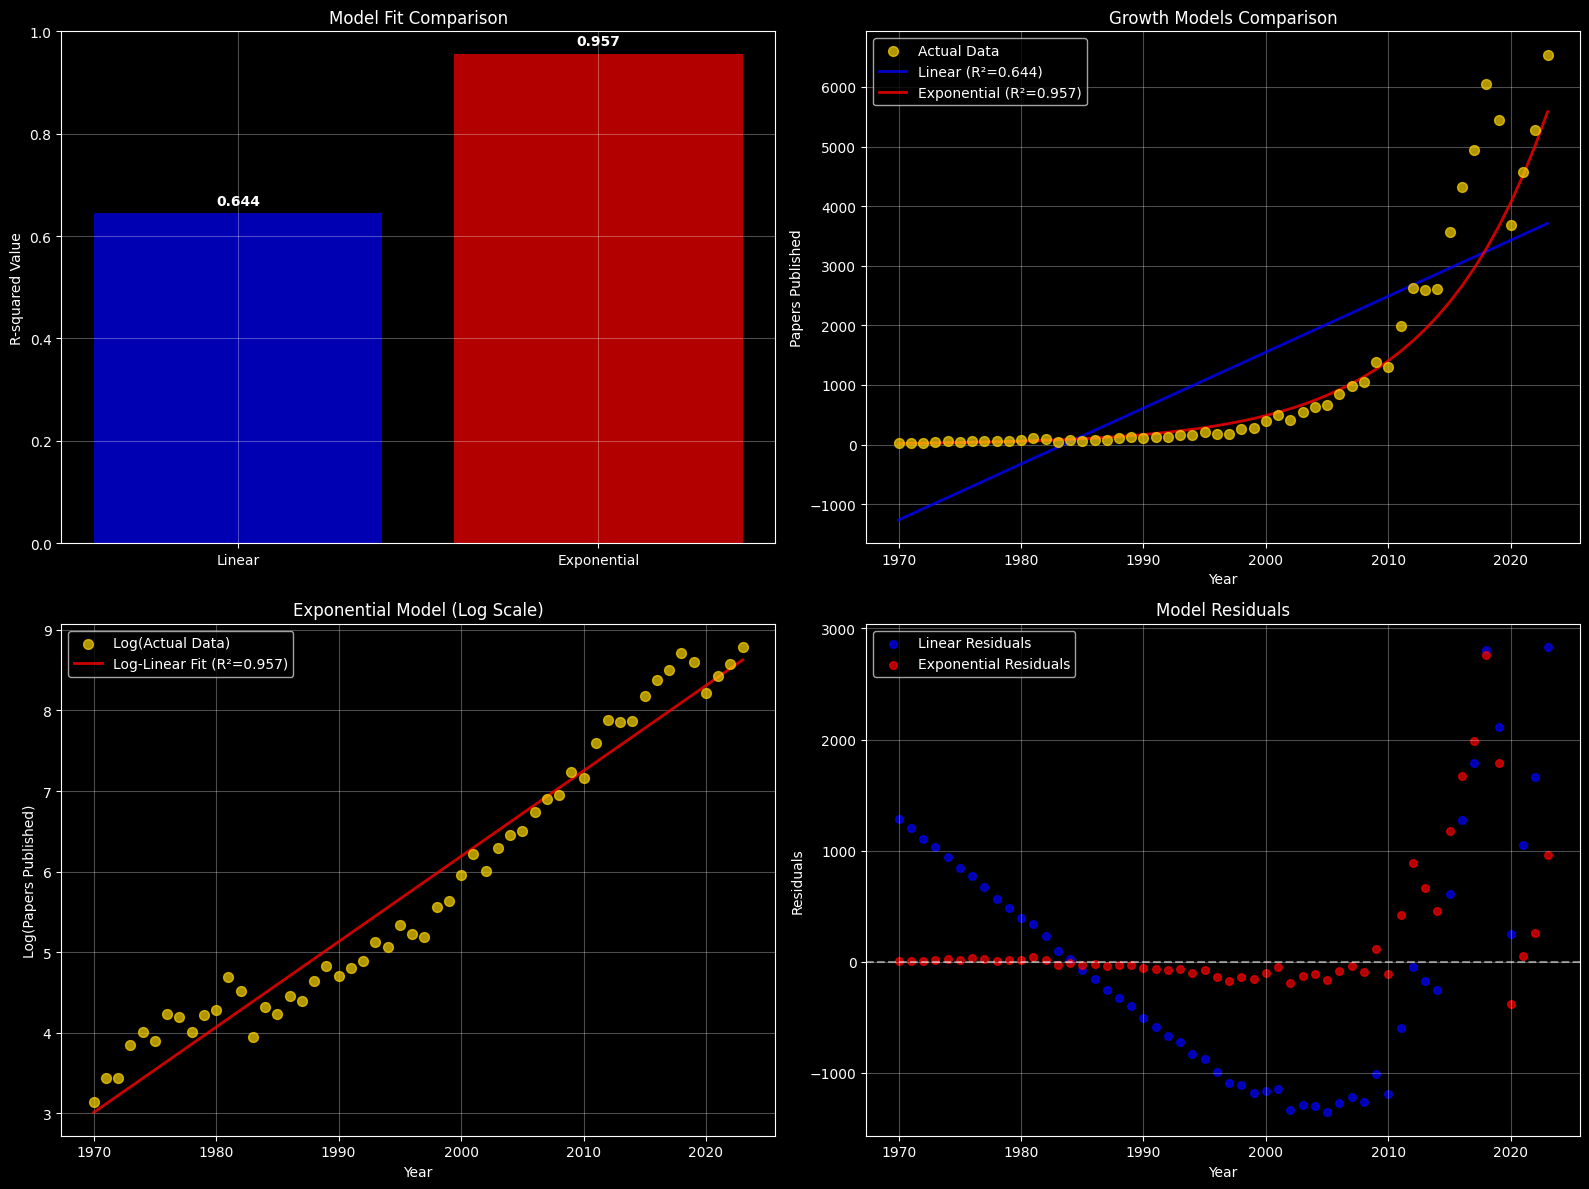


KEY INSIGHTS - TOTAL URBAN ECOLOGY PAPERS GROWTH ANALYSIS:
✓ The field shows EXPONENTIAL growth with 11.2% annual growth rate
✓ Research output doubles every 6.5 years
✓ Exponential model explains 95.7% of variance
✓ Model improvement: +0.3125 R² difference
✓ Growth trend is statistically significant (p < 0.05)
⚠ High growth rate (11.2%/year) may not be sustainable long-term


In [24]:
def linear_trend_analysis(df):
    """
    Perform linear regression analysis for each keyword in the dataframe
    Works with both single keyword (like df_totals) and multiple keyword dataframes (like df_keywords)
    Returns comprehensive trend statistics
    """
    results = []
    
    for keyword in df['search_keyword'].unique():
        keyword_data = df[df['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, counts)
        
        r_squared = r_value**2
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = 'Significantly increasing'
            else:
                trend_interpretation = 'Significantly decreasing'
        else:
            trend_interpretation = 'No significant trend'
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        results.append({
            'keyword': keyword,
            'slope_papers_per_year': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

def log_trend_analysis(df, min_papers=1):
    """
    Perform logarithmic regression analysis for each keyword to test exponential growth
    Works with both single keyword (like df_totals) and multiple keyword dataframes (like df_keywords)
    Uses log(paper_count + 1) to handle zero values
    Returns comprehensive trend statistics for exponential growth patterns
    """
    results = []
    
    for keyword in df['search_keyword'].unique():
        keyword_data = df[df['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        # Filter out years with very low counts if specified
        if min_papers > 0:
            valid_mask = counts >= min_papers
            if valid_mask.sum() < 3:
                continue
            years = years[valid_mask]
            counts = counts[valid_mask]
        
        log_counts = np.log(counts + 1)
        
        if len(years) < 3:
            continue
            
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, log_counts)
        
        r_squared = r_value**2
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        
        annual_growth_rate = (np.exp(slope) - 1) * 100
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = 'Significantly increasing (exponential)'
            else:
                trend_interpretation = 'Significantly decreasing (exponential)'
        else:
            trend_interpretation = 'No significant exponential trend'
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        doubling_time = np.log(2) / slope if slope > 0 else np.inf
        
        results.append({
            'keyword': keyword,
            'log_slope': slope,
            'log_intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'annual_growth_rate_percent': annual_growth_rate,
            'doubling_time_years': doubling_time,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

def compare_linear_vs_exponential(df, min_papers=1):
    """
    Compare linear vs exponential growth models for each keyword in the dataframe
    Works with both single keyword (like df_totals) and multiple keyword dataframes (like df_keywords)
    Returns comparison results
    """
    linear_results = linear_trend_analysis(df)
    log_results = log_trend_analysis(df, min_papers)
    
    comparison = pd.merge(linear_results[['keyword', 'r_squared', 'p_value', 'significant_trend']], 
                         log_results[['keyword', 'r_squared', 'p_value', 'significant_trend', 'annual_growth_rate_percent', 'doubling_time_years']], 
                         on='keyword', suffixes=('_linear', '_log'))
    
    comparison['better_fit'] = np.where(comparison['r_squared_log'] > comparison['r_squared_linear'], 
                                       'Exponential', 'Linear')
    comparison['r_squared_difference'] = comparison['r_squared_log'] - comparison['r_squared_linear']
    
    return comparison, linear_results, log_results

print('COMPREHENSIVE GROWTH ANALYSIS - TOTAL URBAN ECOLOGY PAPERS')
print('=' * 80)

comparison, linear_results, log_results = compare_linear_vs_exponential(df_totals, min_papers=1)

print('\nMODEL COMPARISON RESULTS:')
print('-' * 60)
display_cols = ['keyword', 'r_squared_linear', 'r_squared_log', 'better_fit', 
                'annual_growth_rate_percent', 'r_squared_difference']
print(comparison[display_cols])

print('\nLINEAR MODEL RESULTS:')
print('-' * 40)
linear_total = linear_results.iloc[0]
print(f"Growth rate: {linear_total['slope_papers_per_year']:.2f} papers/year")
print(f"R²: {linear_total['r_squared']:.4f}")
print(f"P-value: {linear_total['p_value']:.2e}")

print('\nEXPONENTIAL MODEL RESULTS:')
print('-' * 40)
log_total = log_results.iloc[0]
print(f"Annual growth rate: {log_total['annual_growth_rate_percent']:.1f}% per year")
print(f"Doubling time: {log_total['doubling_time_years']:.1f} years")
print(f"R²: {log_total['r_squared']:.4f}")
print(f"P-value: {log_total['p_value']:.2e}")

plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model comparison
ax1 = axes[0, 0]
models = ['Linear', 'Exponential']
r_squared_values = [linear_total['r_squared'], log_total['r_squared']]
colors = ['blue', 'red']

bars = ax1.bar(models, r_squared_values, color=colors, alpha=0.7)
ax1.set_ylabel('R-squared Value')
ax1.set_title('Model Fit Comparison')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars, r_squared_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Original data with both fits
ax2 = axes[0, 1]
years = df_totals['year'].values
counts = df_totals['paper_count'].values
predicted_linear = linear_total['slope_papers_per_year'] * years + linear_total['intercept']
predicted_log = np.exp(log_total['log_slope'] * years + log_total['log_intercept']) - 1

ax2.scatter(years, counts, alpha=0.7, s=50, color='#FFD700', label='Actual Data', zorder=3)
ax2.plot(years, predicted_linear, color='blue', linewidth=2, 
         label=f'Linear (R²={linear_total["r_squared"]:.3f})', alpha=0.8)
ax2.plot(years, predicted_log, color='red', linewidth=2, 
         label=f'Exponential (R²={log_total["r_squared"]:.3f})', alpha=0.8)

ax2.set_xlabel('Year')
ax2.set_ylabel('Papers Published')
ax2.set_title('Growth Models Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Log-scale visualization
ax3 = axes[1, 0]
log_counts = np.log(counts + 1)
ax3.scatter(years, log_counts, alpha=0.7, s=50, color='#FFD700', label='Log(Actual Data)', zorder=3)
ax3.plot(years, log_total['log_slope'] * years + log_total['log_intercept'],
         color='red', linewidth=2, label=f'Log-Linear Fit (R²={log_total["r_squared"]:.3f})', alpha=0.8)

ax3.set_xlabel('Year')
ax3.set_ylabel('Log(Papers Published)')
ax3.set_title('Exponential Model (Log Scale)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residuals analysis
ax4 = axes[1, 1]
residuals_linear = counts - predicted_linear
residuals_exp = counts - predicted_log

ax4.scatter(years, residuals_linear, alpha=0.7, s=30, color='blue', label='Linear Residuals')
ax4.scatter(years, residuals_exp, alpha=0.7, s=30, color='red', label='Exponential Residuals')
ax4.axhline(y=0, color='white', linestyle='--', alpha=0.5)

ax4.set_xlabel('Year')
ax4.set_ylabel('Residuals')
ax4.set_title('Model Residuals')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS - TOTAL URBAN ECOLOGY PAPERS GROWTH ANALYSIS:")
print("="*80)

comparison_total = comparison.iloc[0]

if comparison_total['better_fit'] == 'Exponential':
    print(f"✓ The field shows EXPONENTIAL growth with {log_total['annual_growth_rate_percent']:.1f}% annual growth rate")
    print(f"✓ Research output doubles every {log_total['doubling_time_years']:.1f} years")
    print(f"✓ Exponential model explains {log_total['r_squared']*100:.1f}% of variance")
else:
    print(f"✓ The field shows LINEAR growth with {linear_total['slope_papers_per_year']:.2f} papers/year increase")
    print(f"✓ Linear model explains {linear_total['r_squared']*100:.1f}% of variance")

print(f"✓ Model improvement: {comparison_total['r_squared_difference']:+.4f} R² difference")

if log_total['p_value'] < 0.05:
    print("✓ Growth trend is statistically significant (p < 0.05)")
else:
    print("Growth trend is not statistically significant (p ≥ 0.05)")

if log_total['annual_growth_rate_percent'] > 10:
    print(f"⚠ High growth rate ({log_total['annual_growth_rate_percent']:.1f}%/year) may not be sustainable long-term")
else:
    print(f"✓ Moderate growth rate ({log_total['annual_growth_rate_percent']:.1f}%/year) appears sustainable")

### Urban Ecology vs General Ecology: Exponential Growth Comparison

Now let's compare urban ecology research growth against general ecology research to understand if urban environments are gaining research attention faster than the field as a whole.

Since the overlapped lines for yearly published papers showed similar curves, and the above analysis revealed the exponential growth model to be a better fit for urban ecology, we'll assume the same to be true for general ecology, and go straight into only comparing both with an exponential model.

EXPONENTIAL GROWTH COMPARISON: URBAN ECOLOGY vs GENERAL ECOLOGY

EXPONENTIAL MODEL RESULTS:
------------------------------------------------------------
TOTAL:
  Annual growth rate: 11.2% per year
  Doubling time: 6.5 years
  R² (exponential fit): 0.9567
  P-value: 4.04e-37
  Trend: Significantly increasing (exponential)

ECOLOGY:
  Annual growth rate: 7.9% per year
  Doubling time: 9.2 years
  R² (exponential fit): 0.9777
  P-value: 1.20e-44
  Trend: Significantly increasing (exponential)



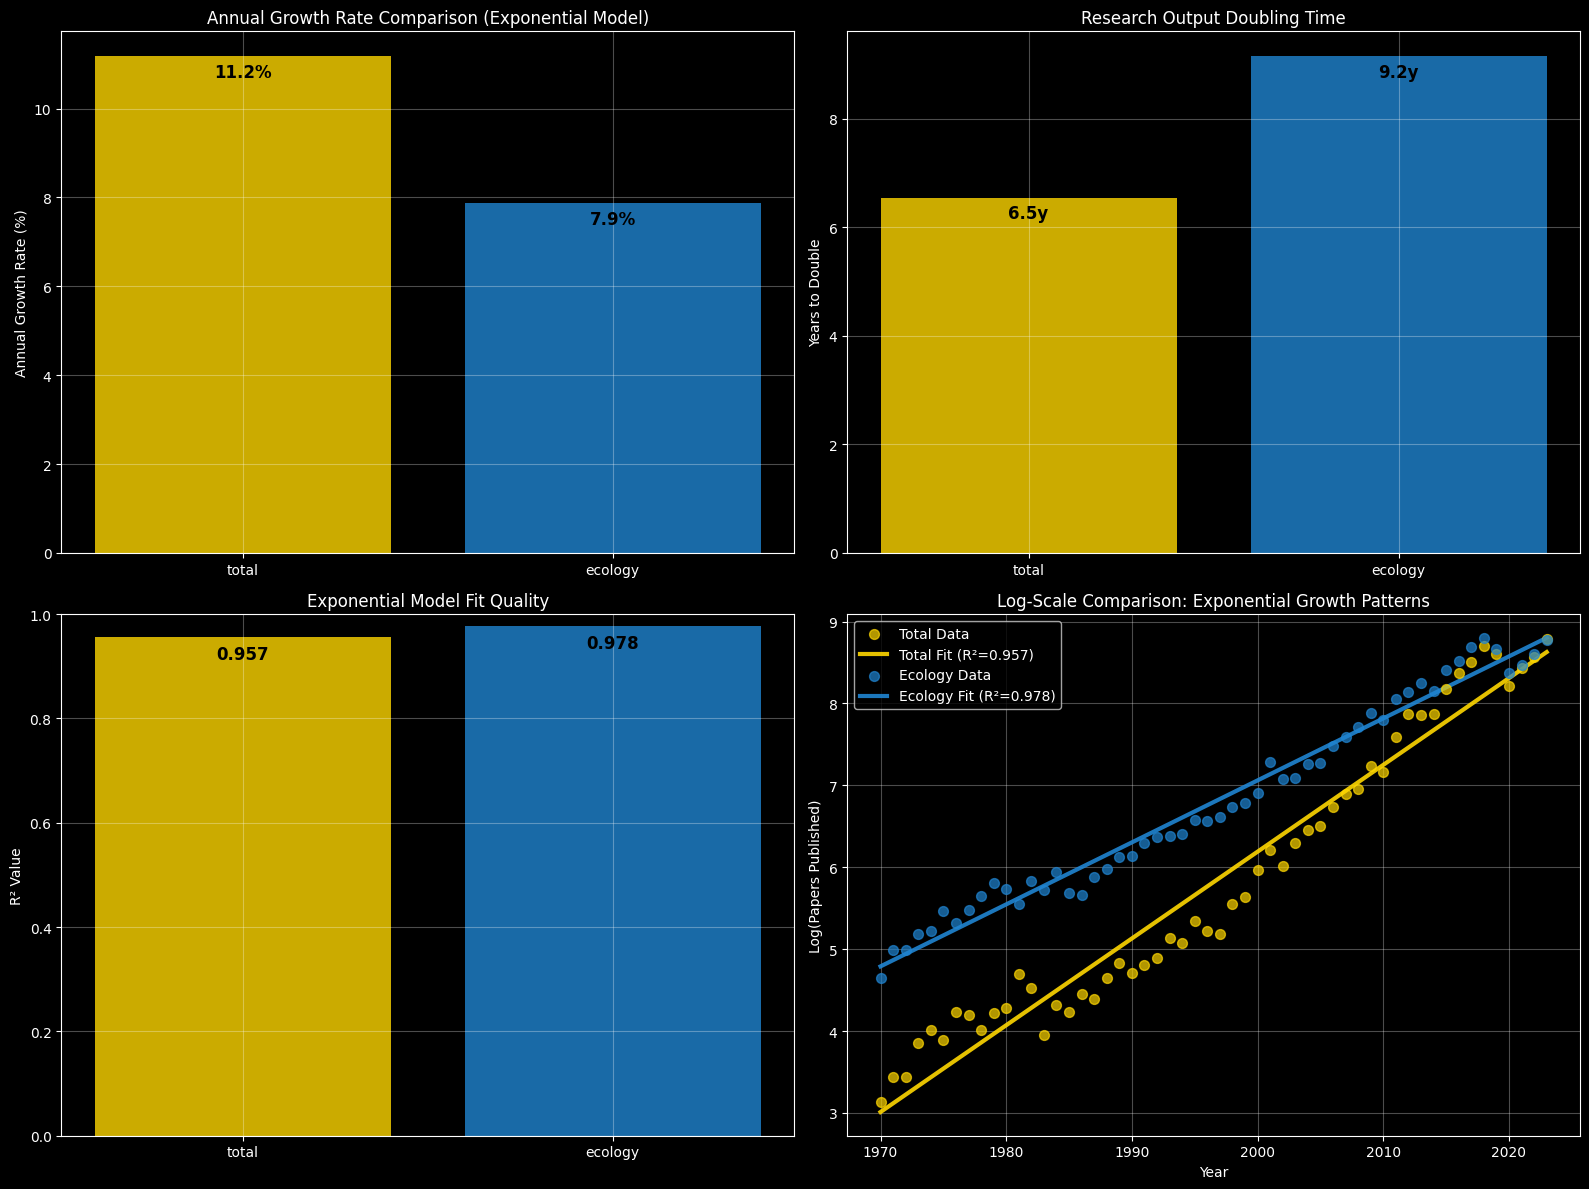


KEY COMPARATIVE INSIGHTS:

GROWTH RATES:
  Urban ecology: 11.2% per year
  General ecology: 7.9% per year
  ✓ Urban ecology is growing 3.3 percentage points FASTER
  ✓ Growth rate ratio: 1.42x

DOUBLING TIMES:
  Urban ecology: 6.5 years
  General ecology: 9.2 years
  ✓ Urban ecology doubles 2.6 years FASTER than general ecology

MODEL FIT QUALITY:
  Urban ecology R²: 0.957
  General ecology R²: 0.978
  ✓ Exponential model fits general ecology better (ΔR² = +0.021)

STATISTICAL SIGNIFICANCE:
  Urban ecology p-value: 4.04e-37 (Significant)
  General ecology p-value: 1.20e-44 (Significant)

RESEARCH IMPLICATIONS:
✓ Urban ecology is emerging as a high-growth research area
✓ Research focus is shifting toward urban environments
✓ Urban ecology may soon rival general ecology in publication volume
✓ Both fields show excellent exponential growth patterns


In [25]:
print('EXPONENTIAL GROWTH COMPARISON: URBAN ECOLOGY vs GENERAL ECOLOGY')
print('=' * 80)

log_comparison_results = log_trend_analysis(df_combined, min_papers=1)

print('\nEXPONENTIAL MODEL RESULTS:')
print('-' * 60)
for _, row in log_comparison_results.iterrows():
    print(f"{row['keyword'].upper()}:")
    print(f"  Annual growth rate: {row['annual_growth_rate_percent']:.1f}% per year") 
    print(f"  Doubling time: {row['doubling_time_years']:.1f} years")
    print(f"  R² (exponential fit): {row['r_squared']:.4f}")
    print(f"  P-value: {row['p_value']:.2e}")
    print(f"  Trend: {row['trend_interpretation']}")
    print()

plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Growth Rate Comparison
ax1 = axes[0, 0] 
keywords = log_comparison_results['keyword'].tolist()
growth_rates = log_comparison_results['annual_growth_rate_percent'].tolist()
colors = ['#FFD700', '#2085D2']

bars = ax1.bar(keywords, growth_rates, color=colors, alpha=0.8)
ax1.set_ylabel('Annual Growth Rate (%)')
ax1.set_title('Annual Growth Rate Comparison (Exponential Model)')
ax1.grid(True, alpha=0.3)

for bar, rate in zip(bars, growth_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.55, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12, color='black')

# 2. Doubling Time Comparison
ax2 = axes[0, 1]
doubling_times = log_comparison_results['doubling_time_years'].tolist()
finite_doubling = [t if t != np.inf else 0 for t in doubling_times]

bars = ax2.bar(keywords, finite_doubling, color=colors, alpha=0.8)
ax2.set_ylabel('Years to Double')
ax2.set_title('Research Output Doubling Time')
ax2.grid(True, alpha=0.3)

for bar, time, orig_time in zip(bars, finite_doubling, doubling_times):
    if orig_time != np.inf:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.45, 
                 f'{time:.1f}y', ha='center', va='bottom', fontweight='bold', fontsize=12, color='black')

# 3. Exponential Fit Quality (R²)
ax3 = axes[1, 0]
r_squared_values = log_comparison_results['r_squared'].tolist()

bars = ax3.bar(keywords, r_squared_values, color=colors, alpha=0.8)
ax3.set_ylabel('R² Value')
ax3.set_title('Exponential Model Fit Quality')
ax3.set_ylim(0, 1)
ax3.grid(True, alpha=0.3)

for bar, r2 in zip(bars, r_squared_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05, 
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12, color='black')

# 4. Log-scale data comparison
ax4 = axes[1, 1]
color_mapping = {'total': '#FFD700', 'ecology': '#2085D2'}

for keyword in df_combined['search_keyword'].unique():
    keyword_data = df_combined[df_combined['search_keyword'] == keyword].sort_values('year')
    years_kw = keyword_data['year'].values
    counts_kw = keyword_data['paper_count'].values
    log_counts_kw = np.log(counts_kw + 1)
    
    log_kw = log_comparison_results[log_comparison_results['keyword'] == keyword].iloc[0]
    color = color_mapping.get(keyword, '#FFD700')
    
    ax4.scatter(years_kw, log_counts_kw, alpha=0.7, s=50, color=color, 
               label=f'{keyword.capitalize()} Data', zorder=3)
    
    # Plot exponential fit line
    predicted_log = log_kw['log_slope'] * years_kw + log_kw['log_intercept']
    ax4.plot(years_kw, predicted_log, color=color, linewidth=3, 
             label=f'{keyword.capitalize()} Fit (R²={log_kw["r_squared"]:.3f})', alpha=0.9)

ax4.set_xlabel('Year')
ax4.set_ylabel('Log(Papers Published)')
ax4.set_title('Log-Scale Comparison: Exponential Growth Patterns')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY COMPARATIVE INSIGHTS:")
print("="*80)

urban_log = log_comparison_results[log_comparison_results['keyword'] == 'total'].iloc[0]
ecology_log = log_comparison_results[log_comparison_results['keyword'] == 'ecology'].iloc[0]

urban_growth = urban_log['annual_growth_rate_percent']
ecology_growth = ecology_log['annual_growth_rate_percent']

print(f"\nGROWTH RATES:")
print(f"  Urban ecology: {urban_growth:.1f}% per year")
print(f"  General ecology: {ecology_growth:.1f}% per year")

if urban_growth > ecology_growth:
    diff = urban_growth - ecology_growth
    print(f"  ✓ Urban ecology is growing {diff:.1f} percentage points FASTER")
    print(f"  ✓ Growth rate ratio: {urban_growth/ecology_growth:.2f}x")
else:
    diff = ecology_growth - urban_growth  
    print(f"  ✓ General ecology is growing {diff:.1f} percentage points faster")
    print(f"  ✓ Growth rate ratio: {ecology_growth/urban_growth:.2f}x")

print(f"\nDOUBLING TIMES:")
print(f"  Urban ecology: {urban_log['doubling_time_years']:.1f} years")
print(f"  General ecology: {ecology_log['doubling_time_years']:.1f} years")

if urban_log['doubling_time_years'] < ecology_log['doubling_time_years']:
    time_diff = ecology_log['doubling_time_years'] - urban_log['doubling_time_years']
    print(f"  ✓ Urban ecology doubles {time_diff:.1f} years FASTER than general ecology")
else:
    time_diff = urban_log['doubling_time_years'] - ecology_log['doubling_time_years'] 
    print(f"  ✓ General ecology doubles {time_diff:.1f} years faster than urban ecology")

print(f"\nMODEL FIT QUALITY:")
print(f"  Urban ecology R²: {urban_log['r_squared']:.3f}")
print(f"  General ecology R²: {ecology_log['r_squared']:.3f}")

if urban_log['r_squared'] > ecology_log['r_squared']:
    print(f"  ✓ Exponential model fits urban ecology better (ΔR² = +{urban_log['r_squared'] - ecology_log['r_squared']:.3f})")
else:
    print(f"  ✓ Exponential model fits general ecology better (ΔR² = +{ecology_log['r_squared'] - urban_log['r_squared']:.3f})")

print(f"\nSTATISTICAL SIGNIFICANCE:")
print(f"  Urban ecology p-value: {urban_log['p_value']:.2e} ({'Significant' if urban_log['p_value'] < 0.05 else 'Not significant'})")
print(f"  General ecology p-value: {ecology_log['p_value']:.2e} ({'Significant' if ecology_log['p_value'] < 0.05 else 'Not significant'})")

print(f"\n" + "="*80)
print("RESEARCH IMPLICATIONS:")
print("="*80)

if urban_growth > ecology_growth:
    print("✓ Urban ecology is emerging as a high-growth research area")
    print("✓ Research focus is shifting toward urban environments")
    print("✓ Urban ecology may soon rival general ecology in publication volume")
    if urban_growth > 15:
        print("⚠ Very high growth rate may indicate emerging field dynamics or data collection effects")
else:
    print("✓ General ecology maintains steady growth advantage")
    print("✓ Urban ecology growing but not outpacing the broader field")

if urban_log['r_squared'] > 0.9 and ecology_log['r_squared'] > 0.9:
    print("✓ Both fields show excellent exponential growth patterns")
elif min(urban_log['r_squared'], ecology_log['r_squared']) > 0.8:
    print("✓ Both fields show strong exponential growth patterns")
else:
    print("⚠ Growth patterns may be more complex than simple exponential models")

==========================================================================
### Per Keyword Regression Analysis

Now we'll move on to analysing each of the keywords, performing linear regression on both the regular data, then on a log-transformed data to see if any of the keywords might fit better a linear growth model. 

COMPREHENSIVE GROWTH ANALYSIS

MODEL COMPARISON RESULTS:
------------------------------------------------------------
              keyword  r_squared_linear  r_squared_log   better_fit  \
2     urban ecosystem          0.615529       0.952564  Exponential   
3  urban green spaces          0.615049       0.946375  Exponential   
1       urban ecology          0.646892       0.947195  Exponential   
0  urban biodiversity          0.674296       0.939802  Exponential   
4    urban vegetation          0.693672       0.946765  Exponential   
5      urban wildlife          0.719227       0.961730  Exponential   

   annual_growth_rate_percent  r_squared_difference  
2                   12.294559              0.337035  
3                   12.061090              0.331326  
1                   10.617228              0.300303  
0                   17.977592              0.265506  
4                    8.853252              0.253093  
5                    8.589296              0.242503  


LOGA

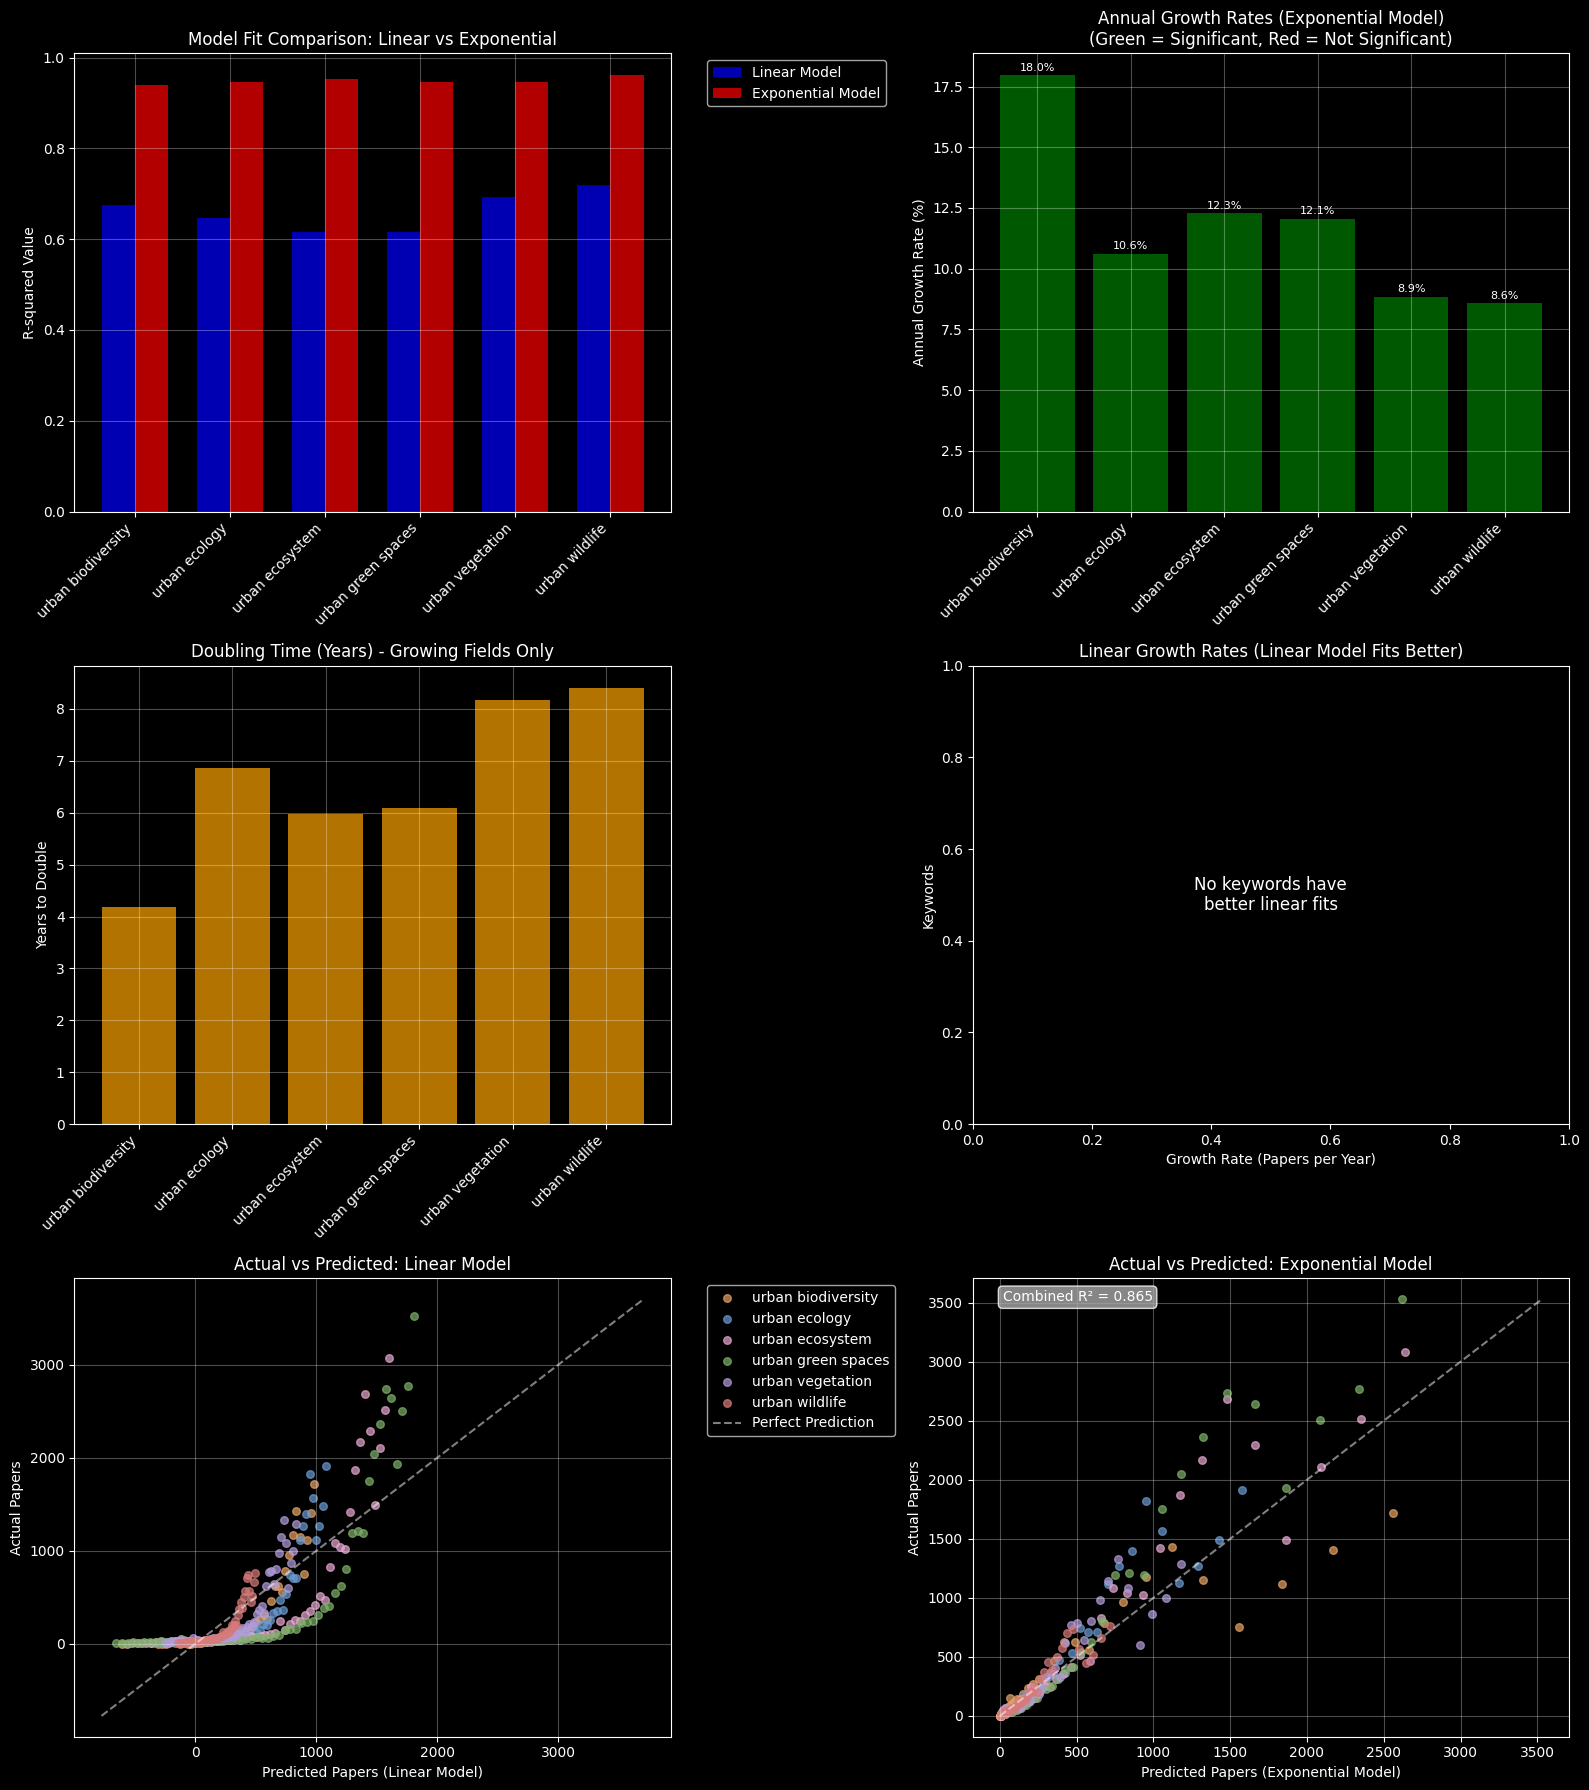

In [26]:
print('COMPREHENSIVE GROWTH ANALYSIS')
print('=' * 80)

comparison, linear_results, log_results = compare_linear_vs_exponential(df_keywords, min_papers=1)

print('\nMODEL COMPARISON RESULTS:')
print('-' * 60)
display_cols = ['keyword', 'r_squared_linear', 'r_squared_log', 'better_fit', 
                'annual_growth_rate_percent', 'r_squared_difference']
print(comparison[display_cols].sort_values('r_squared_difference', ascending=False))

print('\n\nLOGARITHMIC REGRESSION RESULTS (Testing Exponential Growth):')
print('-' * 80)
log_display_cols = ['keyword', 'annual_growth_rate_percent', 'doubling_time_years', 
                   'r_squared', 'p_value', 'trend_interpretation']
print(log_results[log_display_cols].sort_values('annual_growth_rate_percent', ascending=False))

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. R-squared comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison))
width = 0.35
ax1.bar(x_pos - width/2, comparison['r_squared_linear'], width, label='Linear Model', alpha=0.7, color='blue')
ax1.bar(x_pos + width/2, comparison['r_squared_log'], width, label='Exponential Model', alpha=0.7, color='red')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison['keyword'], rotation=45, ha='right')
ax1.set_ylabel('R-squared Value')
ax1.set_title('Model Fit Comparison: Linear vs Exponential')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Annual growth rates from exponential model
ax2 = axes[0, 1]
growth_rates = log_results['annual_growth_rate_percent']
colors = ['green' if sig else 'red' for sig in log_results['significant_trend']]
bars = ax2.bar(range(len(log_results)), growth_rates, color=colors, alpha=0.7)
ax2.set_xticks(range(len(log_results)))
ax2.set_xticklabels(log_results['keyword'], rotation=45, ha='right')
ax2.set_ylabel('Annual Growth Rate (%)')
ax2.set_title('Annual Growth Rates (Exponential Model)\n(Green = Significant, Red = Not Significant)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

for bar, rate in zip(bars, growth_rates):
    if not np.isnan(rate) and abs(rate) < 1000:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=8)

# 3. Doubling times (only for positive growth)
ax3 = axes[1, 0]
finite_doubling = log_results[log_results['doubling_time_years'] != np.inf]
if len(finite_doubling) > 0:
    ax3.bar(range(len(finite_doubling)), finite_doubling['doubling_time_years'], alpha=0.7, color='orange')
    ax3.set_xticks(range(len(finite_doubling)))
    ax3.set_xticklabels(finite_doubling['keyword'], rotation=45, ha='right')
    ax3.set_ylabel('Years to Double')
    ax3.set_title('Doubling Time (Years) - Growing Fields Only')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No fields with\npositive exponential growth', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Doubling Time (Years)')

# 4. Linear trend slopes with confidence intervals (conditional on better fit)
ax4 = axes[1, 1]

linear_better_mask = comparison['better_fit'] == 'Linear'
if linear_better_mask.any():
    linear_subset = linear_results[linear_results['keyword'].isin(comparison[linear_better_mask]['keyword'])]
    
    colors = ['green' if sig else 'red' for sig in linear_subset['significant_trend']]
    keywords = linear_subset['keyword']
    slopes = linear_subset['slope_papers_per_year']
    ci_lower = linear_subset['slope_ci_lower']
    ci_upper = linear_subset['slope_ci_upper']
    
    y_pos = np.arange(len(keywords))
    ax4.barh(y_pos, slopes, color=colors, alpha=0.7)
    ax4.errorbar(slopes, y_pos, xerr=[slopes - ci_lower, ci_upper - slopes], 
                fmt='none', color='black', capsize=5)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(keywords)
    ax4.set_xlabel('Growth Rate (Papers per Year)')
    ax4.set_title('Linear Growth Rates (Linear Model Fits Better)\n(Green = Significant, Red = Not Significant)')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No keywords have\nbetter linear fits', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Linear Growth Rates (Linear Model Fits Better)')
    ax4.set_xlabel('Growth Rate (Papers per Year)')
    ax4.set_ylabel('Keywords')

# 5. Actual vs Predicted - Linear Model
ax5 = axes[2, 0]
for i, keyword in enumerate(linear_results['keyword']):
    keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    slope = linear_results[linear_results['keyword'] == keyword]['slope_papers_per_year'].iloc[0]
    intercept = linear_results[linear_results['keyword'] == keyword]['intercept'].iloc[0]
    predicted = slope * years + intercept
    
    try:
        color = color_map.get(keyword, plt.cm.tab10(i % 10))
    except:
        color = plt.cm.tab10(i % 10)
    
    ax5.scatter(predicted, counts, alpha=0.7, label=keyword, s=30, color=color)

# Perfect prediction line
max_val = max(ax5.get_xlim()[1], ax5.get_ylim()[1])
min_val = min(ax5.get_xlim()[0], ax5.get_ylim()[0])
ax5.plot([min_val, max_val], [min_val, max_val], 'w--', alpha=0.5, label='Perfect Prediction')
ax5.set_xlabel('Predicted Papers (Linear Model)')
ax5.set_ylabel('Actual Papers')
ax5.set_title('Actual vs Predicted: Linear Model')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Actual vs Predicted - Exponential Model
ax6 = axes[2, 1]

all_actual_exp = []
all_predicted_exp = []

for i, keyword in enumerate(log_results['keyword']):
    keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    min_papers = 1
    valid_mask = counts >= min_papers
    if valid_mask.sum() < 3:
        continue
    
    years_filtered = years[valid_mask]
    counts_filtered = counts[valid_mask]
    
    log_slope = log_results[log_results['keyword'] == keyword]['log_slope'].iloc[0]
    log_intercept = log_results[log_results['keyword'] == keyword]['log_intercept'].iloc[0]
    
    predicted_log = log_slope * years_filtered + log_intercept
    predicted_counts = np.exp(predicted_log) - 1
    
    all_actual_exp.extend(counts_filtered)
    all_predicted_exp.extend(predicted_counts)
    
    try:
        color = color_map.get(keyword, plt.cm.tab10(i % 10))
    except:
        color = plt.cm.tab10(i % 10)
    
    ax6.scatter(predicted_counts, counts_filtered, alpha=0.7, label=keyword, s=30, color=color)

# Perfect prediction line
if len(all_actual_exp) > 0:
    max_val = max(max(all_predicted_exp), max(all_actual_exp))
    min_val = max(0, min(min(all_predicted_exp), min(all_actual_exp)))  # Don't go below 0
    ax6.plot([min_val, max_val], [min_val, max_val], 'w--', alpha=0.5, label='Perfect Prediction')
    
    if len(all_actual_exp) > 1:
        ss_res = np.sum((np.array(all_actual_exp) - np.array(all_predicted_exp)) ** 2)
        ss_tot = np.sum((np.array(all_actual_exp) - np.mean(all_actual_exp)) ** 2)
        r_squared_combined = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        ax6.text(0.05, 0.95, f'Combined R² = {r_squared_combined:.3f}', 
                transform=ax6.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="darkgray", alpha=0.8))

ax6.set_xlabel('Predicted Papers (Exponential Model)')
ax6.set_ylabel('Actual Papers')
ax6.set_title('Actual vs Predicted: Exponential Model')
ax6.grid(True, alpha=0.3)

if len(all_actual_exp) > 0:
    residuals = np.array(all_actual_exp) - np.array(all_predicted_exp)
    mean_residual = np.mean(residuals)
    if abs(mean_residual) > np.std(all_actual_exp) * 0.1:
        bias_direction = "above" if mean_residual > 0 else "below"
        ax6.text(0.05, 0.85, f'Systematic bias: points tend to be {bias_direction} line\n(Mean residual: {mean_residual:.1f})', 
                transform=ax6.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.8),
                fontsize=9)


plt.tight_layout()
plt.show()

==========================================================================
### Geographical Data Analysis

In this next step, I'll obtain geographical data to draw a choropleth map with the publication data. We'll first need to perform some API calls again to fill in the gaps of our country ISO data, since OpenAlex doesn't have a lot of institution data indexed.


We'll start by doing more OpenAlex calls to fill a second table in our papers.db, gathering every first author, as we ll as their affiliation (institution) and its Research Organization Registry (ROR).
We'll use this ID to make some more API call to ROR as they'll help us obtain the missing country data.

In [27]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_countries = pd.read_sql_query("""
    SELECT 
        firstAuthorCountryIso as alpha2_code,
        COUNT(*) as paper_count
    FROM papers
    WHERE firstAuthorCountryIso IS NOT NULL
    GROUP BY firstAuthorCountryIso
    ORDER BY paper_count DESC
    """, conn)

df_countries['alpha3_code'] = df_countries['alpha2_code'].apply(convert_alpha2_to_alpha3)
df_countries['country_name'] = df_countries['alpha2_code'].apply(get_country_name)

unmapped = df_countries[df_countries['alpha3_code'].isna()]
if not unmapped.empty:
    print('Found unmapped country codes:')
    for _, row in unmapped.iterrows():
        print(f'{row["alpha2_code"]}: {row["paper_count"]} papers')

df_countries.dropna(subset=['alpha3_code', 'country_name'], inplace=True)

df_countries.head(20)

Found unmapped country codes:
XK: 3 papers


,alpha2_code,paper_count,alpha3_code,country_name
0,US,13480,USA,United States
1,GB,6130,GBR,United Kingdom
2,AU,2461,AUS,Australia
3,DE,2456,DEU,Germany
4,IT,2182,ITA,Italy
5,IN,1795,IND,India
6,CA,1606,CAN,Canada
7,CN,1539,CHN,China
8,FR,1521,FRA,France
9,BR,1516,BRA,Brazil


In [6]:
fig = px.choropleth(
    df_countries, 
    locations='alpha3_code',
    color='paper_count',
    hover_name='country_name',
    hover_data={
        'alpha3_code': True, 
        'paper_count': ':,',
        'country_name': False
    },
    color_continuous_scale='Viridis',
    title='Global Distribution of Urban Ecology Research Papers by First Author Country',
    labels={
        'paper_count': 'Number of Papers',
        'alpha3_code': 'ISO Alpha-3'
    }
)

fig.update_traces(
    marker_line_color='white',
    marker_line_width=0.5
)

fig.update_layout(
    template='plotly_dark',
    width=1200,
    height=700,
    title_font_size=16,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        coastlinecolor='white',
        coastlinewidth=0.5,
        showland=True,
        landcolor='rgb(70, 70, 70)',
        showocean=True,
        oceancolor='rgb(30, 30, 30)',
        projection_type='natural earth',
        bgcolor='rgba(0,0,0,0)',
    ),
    coloraxis_colorbar=dict(
        title_font_color='white',
        tickfont_color='white'
    )
)

fig.show()

print('=' * 80)

fig_treemap = px.treemap(
    df_countries.head(20),
    names='country_name',
    values='paper_count',
    parents=[''] * 20, 
    title='Top 20 Countries by Urban Ecology Research Output',
    labels={'paper_count': 'Number of Papers', 'country_name': 'Country'},
    color='paper_count',
    color_continuous_scale='Viridis',
    hover_data={
        'alpha2_code': True,
        'alpha3_code': True,
        'paper_count': ':,',
    }
)

# Threshold calculation to avoid unreadable text
max_val = df_countries.head(20)['paper_count'].max()
min_val = df_countries.head(20)['paper_count'].min()
threshold = min_val + (max_val - min_val) * 0.7

text_colors = ['black' if val > threshold else 'white' for val in df_countries.head(20)['paper_count']]

fig_treemap.update_traces(
    textinfo='label+value',
    textfont_size=12,
    textfont_color=text_colors,
    hovertemplate='<b>%{label}</b><br>' +
                  'Papers: %{value:,}<br>' +
                  'ISO-3: %{customdata[1]}<br>' +
                  '<extra></extra>'
)

fig_treemap.update_layout(
    height=700,
    width=1200,
    template='plotly_dark',
    font=dict(size=14),
    title_font_size=18,
    margin=dict(t=50, l=25, r=25, b=25)
)

fig_treemap.show()

As one could expect, the USA shows up on top, since they do have some of the largest research institutions in the world. To me, the surprising data comes from the UK, that manages to produce just under half the amount of papers while having less than a fourth of the population of the USA.

Other noteworthy datapoints to me are China and India, which I expected to have higher volume of publications by sheer number of their population. But perhaps, being emergent economies, scientific research wasn't really a thing until recently.

To look into that, let's create a heatmap with temporal data for the top 20 paper producing countries.

In [53]:
top_20_countries = df_countries.head(20)['alpha2_code'].tolist()

country_year_query = """
SELECT 
    year,
    firstAuthorCountryIso as country,
    COUNT(*) as paper_count
FROM papers 
WHERE firstAuthorCountryIso IS NOT NULL AND firstAuthorCountryIso != '' 
GROUP BY year, firstAuthorCountryIso
ORDER BY year, firstAuthorCountryIso
"""

df_country_years = pd.read_sql_query(country_year_query, conn)

df_country_years_top20 = df_country_years[df_country_years['country'].isin(top_20_countries)]

df_heatmap_data = df_country_years_top20.copy()
df_heatmap_data['country_name'] = df_heatmap_data['country'].apply(get_country_name)

df_heatmap = df_heatmap_data.pivot(index='country_name', columns='year', values='paper_count').fillna(0)

df_heatmap_masked = df_heatmap.replace(0, np.nan)


fig_heatmap = go.Figure(data=go.Heatmap(
    z=df_heatmap_masked.values,
    x=df_heatmap_masked.columns,
    y=df_heatmap_masked.index,
    colorscale='Viridis',
    hovertemplate='<b>%{y}</b><br>' +
                  'Year: %{x}<br>' +
                  'Papers: %{z}<br>' +
                  '<extra></extra>',
    colorbar=dict(title='Number of Papers'),
    showscale=True
))

fig_heatmap.update_layout(
    title='Research Output Heatmap: Top 20 Countries Over Time',
    xaxis_title='Year',
    yaxis_title='Country',
    template='plotly_dark',
    width=1200,
    height=800,
    xaxis=dict(
        tickangle=45,
        dtick=5,
        tick0=1970,
        showgrid=False 
    ),
    yaxis=dict(showgrid=False),
    font=dict(size=12)
)

fig_heatmap.show()

In [54]:
all_years = df_country_years_top20['year'].unique()
all_countries = df_country_years_top20['country'].unique()

# Create a complete grid of year-country combinations
import itertools
complete_combinations = list(itertools.product(all_years, all_countries))
df_complete = pd.DataFrame(complete_combinations, columns=['year', 'country'])

df_animated = df_complete.merge(df_country_years_top20[['year', 'country', 'paper_count']], 
                               on=['year', 'country'], how='left')
df_animated['paper_count'] = df_animated['paper_count'].fillna(0)

df_animated['country_name'] = df_animated['country'].apply(get_country_name)

df_animated = df_animated.sort_values(['year', 'paper_count'], ascending=[True, False])

all_country_names = sorted(df_animated['country_name'].unique())

fig_animated = px.bar(
    df_animated,
    x='paper_count',
    y='country_name',
    animation_frame='year',
    title='Research Output by Country Over Time (Animated)',
    orientation='h',
    labels={'paper_count': 'Number of Papers', 'country_name': 'Country'},
    color='paper_count',
    color_continuous_scale='Viridis',
    range_x=[0, df_animated['paper_count'].max() * 1.05],
    category_orders={'country_name': all_country_names}
)

fig_animated.update_layout(
    template='plotly_dark',
    width=1000,
    height=700,
    xaxis_title='Number of Papers',
    yaxis_title='Country',
    font=dict(size=12),
    yaxis={'categoryorder': 'array', 'categoryarray': all_country_names}
)

fig_animated.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500
fig_animated.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 300

fig_animated.show()

Indeed we can see that, while the USA and UK where scientifically actve ever since urban ecology started gaining interest back in the 1970's, the rest of the world only started to look more ate the field much later. Of note, we see Italy, Germany, China, and Brazil starting to inch closer to the UK in production.

That's it. We looked briefly into the output of urban-related studies over the years and could see some interesting data from that. It indeed shows accelerated growth and more widspread interest, with potential to become more popular than general ecology in the future. However, that data is recent, so only time will tell if this trend will maintain in the future.